# Transfer learning and fine-tuning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf

## Data preprocessing

### Data download

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 128
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 4s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


Show the first nine images and labels from the training set:

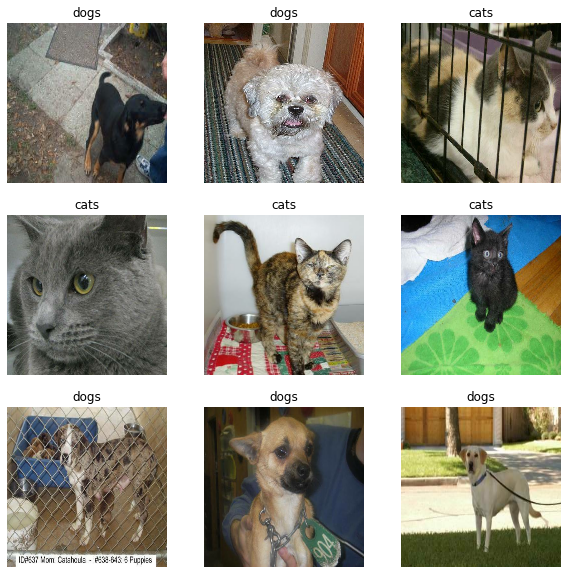

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using `tf.data.experimental.cardinality`, then move 20% of them to a test set.

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

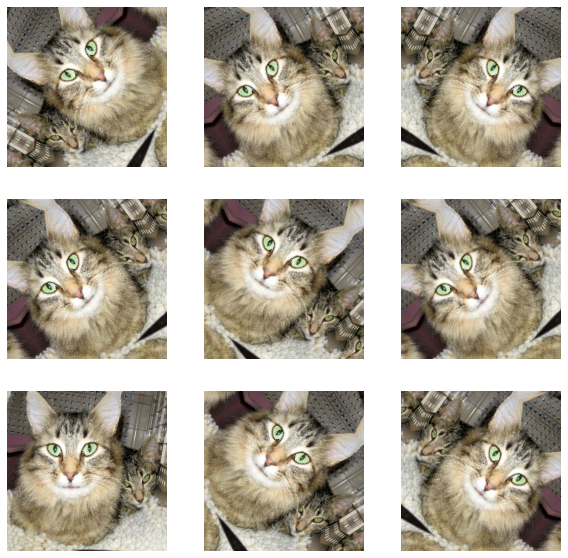

In [10]:
# augmentation sample
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
### REPLACE THIS FOR NEW MODEL! (1)

preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0, 255]` to `[-1, 1]` using `tf.keras.layers.Rescaling`.

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Note: If using other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1, 1]` or `[0, 1]`, or use the included `preprocess_input` function.

## Create the base model from the pre-trained convnets

In [14]:
# Create the base model from the pre-trained model MobileNet
# REPLACE THIS FOR NEW MODEL e.g. EfficientNet (2)

IMG_SHAPE = IMG_SIZE + (3,)
# base_model = create_model()
base_model = tf.keras.applications.EfficientNetV2B1(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

28456008/28456008 [==============================] - 2s 0us/step


In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 5, 5, 1280)


## Feature extraction

### Freeze the convolutional base

In [16]:
base_model.trainable = False

In [17]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetv2-b1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 160, 160, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 160, 160, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 32)   864         ['normalization[0

### Add a classification head

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 1280)


In [19]:
# (3)  Change this

prediction_layer = tf.keras.layers.Dense(1) # This is one only because the output is Boolean
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(128, 1)


In [20]:
# As previously mentioned, use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 5, 5, 1280)       6931124   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [23]:
len(model.trainable_variables)

2

### Train the model


In [24]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 9s 305ms/step - loss: 0.6571 - accuracy: 0.5367


In [25]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.66
initial accuracy: 0.54


In [26]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


16/16 [==============================] - 25s 888ms/step - loss: 0.6484 - accuracy: 0.5725 - val_loss: 0.6031 - val_accuracy: 0.5642
Epoch 2/10
16/16 [==============================] - 14s 827ms/step - loss: 0.6029 - accuracy: 0.5955 - val_loss: 0.5533 - val_accuracy: 0.6021
Epoch 3/10
16/16 [==============================] - 14s 810ms/step - loss: 0.5549 - accuracy: 0.6345 - val_loss: 0.5168 - val_accuracy: 0.6227
Epoch 4/10
16/16 [==============================] - 14s 819ms/step - loss: 0.5231 - accuracy: 0.6615 - val_loss: 0.4839 - val_accuracy: 0.6514
Epoch 5/10
16/16 [==============================] - 14s 825ms/step - loss: 0.4906 - accuracy: 0.6905 - val_loss: 0.4505 - val_accuracy: 0.6835
Epoch 6/10
16/16 [==============================] - 14s 812ms/step - loss: 0.4658 - accuracy: 0.7115 - val_loss: 0.4260 - val_accuracy: 0.7053
Epoch 7/10
16/16 [==============================] - 15s 831ms/step - loss: 0.4372 - accuracy: 0.7385 - val_loss: 0.4001 - val_accuracy: 0.7397
Epoch 8/10

### Learning curves

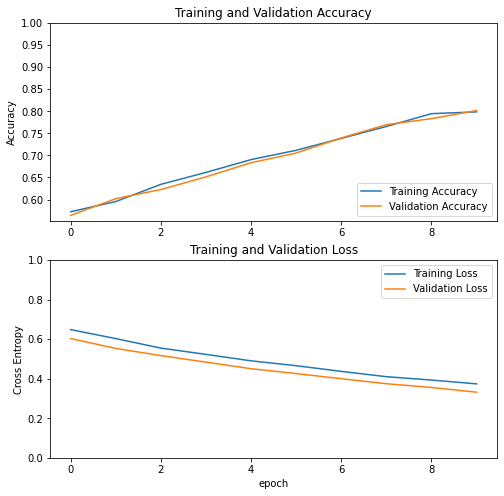

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

los = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning


### Un-freeze the top layers of the model


In [28]:
base_model.trainable = True

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2
print("fine_tune_at: ", fine_tune_at)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  334
fine_tune_at:  167


### Compile the model

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetv2-b1 (Function  (None, 5, 5, 1280)       6931124   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

In [32]:
len(model.trainable_variables)

148

### Continue training the model

In [33]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


16/16 [==============================] - 46s 1s/step - loss: 0.3078 - accuracy: 0.8700 - val_loss: 0.2342 - val_accuracy: 0.9209
Epoch 11/20
16/16 [==============================] - 16s 940ms/step - loss: 0.2428 - accuracy: 0.9135 - val_loss: 0.1832 - val_accuracy: 0.9461
Epoch 12/20
16/16 [==============================] - 17s 977ms/step - loss: 0.1902 - accuracy: 0.9365 - val_loss: 0.1389 - val_accuracy: 0.9690
Epoch 13/20
16/16 [==============================] - 16s 952ms/step - loss: 0.1618 - accuracy: 0.9420 - val_loss: 0.1086 - val_accuracy: 0.9782
Epoch 14/20
16/16 [==============================] - 17s 947ms/step - loss: 0.1307 - accuracy: 0.9610 - val_loss: 0.0910 - val_accuracy: 0.9805
Epoch 15/20
16/16 [==============================] - 16s 978ms/step - loss: 0.1122 - accuracy: 0.9630 - val_loss: 0.0768 - val_accuracy: 0.9874
Epoch 16/20
16/16 [==============================] - 16s 927ms/step - loss: 0.0966 - accuracy: 0.9725 - val_loss: 0.0669 - val_accuracy: 0.9862
Epoch 1

In [34]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

los += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

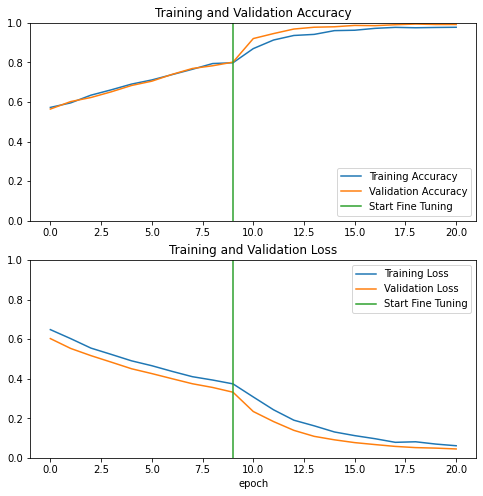

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(los, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 1s 1s/step - loss: 0.0382 - accuracy: 0.9844
Test accuracy : 0.984375


And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1]
Labels:
 [1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 0
 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1]


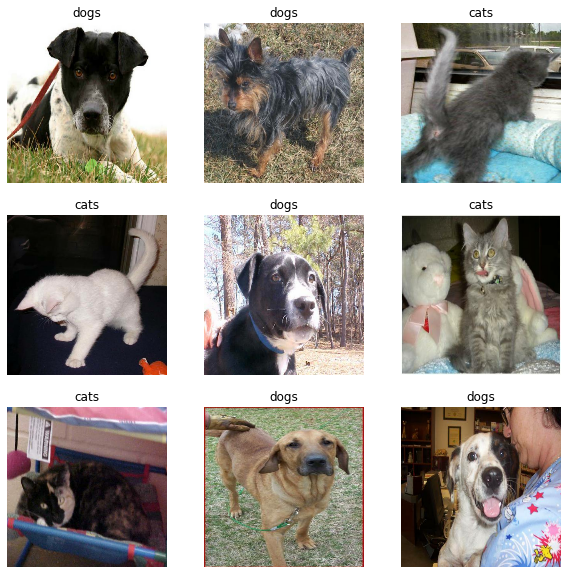

In [37]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(5, 5))
for i in range(128):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Confusion Matrix

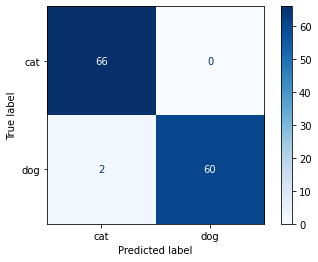

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

labels = ['cat', 'dog']

cm = confusion_matrix(label_batch, predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [39]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predictions.numpy(), target_names=labels))

              precision    recall  f1-score   support

         cat       0.97      1.00      0.99        66
         dog       1.00      0.97      0.98        62

    accuracy                           0.98       128
   macro avg       0.99      0.98      0.98       128
weighted avg       0.98      0.98      0.98       128



## Summary

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.

To learn more, visit the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).
